# sprint ディープラーニングフレームワーク２

# 【問題1】公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

### 画像選択

In [36]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

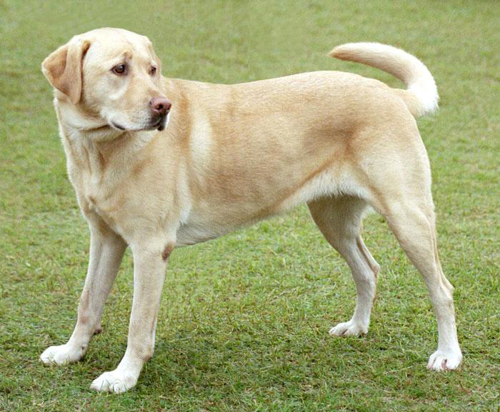

In [37]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

### 特徴抽出モデルの準備
事前に訓練された画像分類モデルをダウンロード(InceptionV3)

In [38]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [39]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

### 損失の計算

In [40]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

### 勾配上昇

In [41]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [42]:
deepdream = DeepDream(dream_model)

### メインループ

In [70]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))

    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

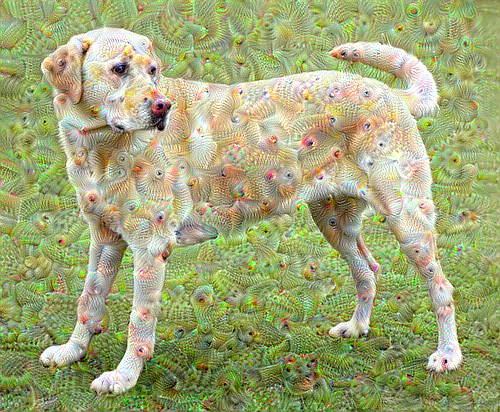

In [71]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

### 1オクターブ上げる

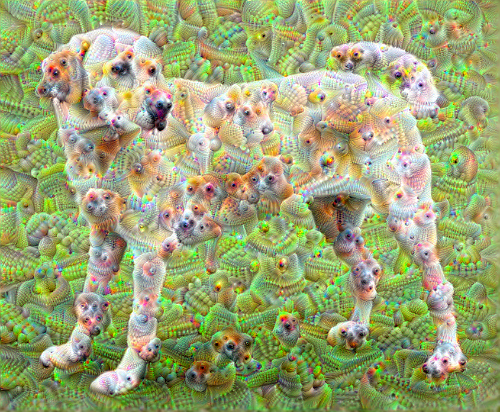

125.22254729270935

In [39]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

### オプション：タイルでスケールアップする

In [74]:
def random_roll(img, maxroll):
    # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0],shift[1] 
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled

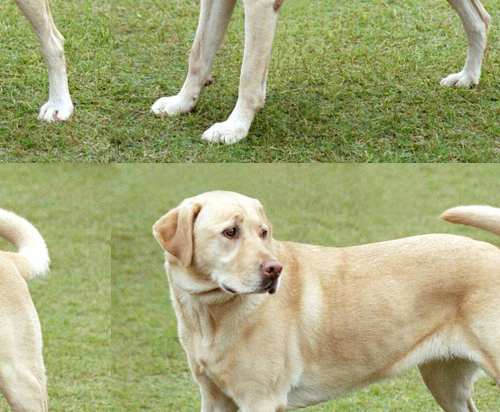

In [76]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [85]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),)
      )
    def __call__(self, img, tile_size=512):
        shift_down, shift_right, img_rolled = random_roll(img, tile_size)

        # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)

        
        print(tf.range(0, img_rolled.shape[0], tile_size))
        print(tf.range(0, img_rolled.shape[1], tile_size))
        
        
        # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])
        
        for x in xs:
            for y in ys:
                # Calculate the gradients for this tile.
                with tf.GradientTape() as tape:
                    # This needs gradients relative to `img_rolled`.
                    # `GradientTape` only watches `tf.Variable`s by default.
                    tape.watch(img_rolled)

                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                    loss = calc_loss(img_tile, self.model)

                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients 

In [83]:
get_tiled_gradients = TiledGradients(dream_model)

In [79]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print ("Octave {}, Step {}".format(octave, step))

    result = deprocess(img)
    return result

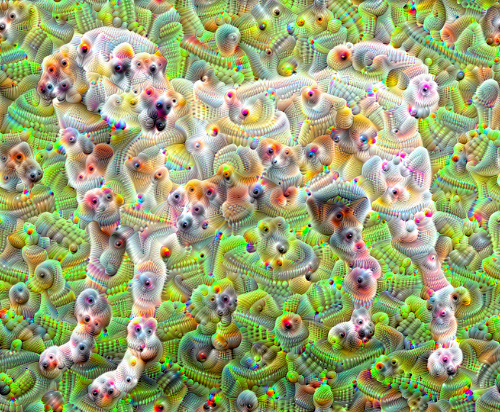

In [45]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

# 異なるフレームワークへの書き換え
* Iris（Iris-versicolorとIris-virginicaのみの2値分類）
* Iris（3種類全ての目的変数を使用して多値分類）
* House Prices
* MNIST

# 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [2]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1

### １次元でも２次元でも可能
### int型のみOK
y = y.astype(np.int)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

In [5]:
print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

64
16
20


In [20]:
K.clear_session( )

In [21]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1

### １次元でも２次元でも可能
### int型のみOK
y = y.astype(np.int)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

### keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_hidden1, activation = "tanh", input_shape=(n_input, )),
    tf.keras.layers.Dense(n_hidden2, activation = "tanh"),
    tf.keras.layers.Dense(n_classes, activation = "sigmoid")
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                   validation_data=(X_val, y_val))
# test
score = model.evaluate(X_test, y_test, verbose=0)
print('test loss:', score[0])
print('test accuracy:', score[1])

Train on 64 samples, validate on 16 samples
Epoch 1/10
64/64 [==============================] - 0s 5ms/sample - loss: 7.1481 - accuracy: 0.5312 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 2/10
64/64 [==============================] - 0s 235us/sample - loss: 7.1481 - accuracy: 0.5312 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 3/10
64/64 [==============================] - 0s 213us/sample - loss: 7.1481 - accuracy: 0.5312 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 4/10
64/64 [==============================] - 0s 264us/sample - loss: 7.1481 - accuracy: 0.5312 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 5/10
64/64 [==============================] - 0s 207us/sample - loss: 7.1481 - accuracy: 0.5312 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 6/10
64/64 [==============================] - 0s 226us/sample - loss: 7.1481 - accuracy: 0.5312 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 7/10
64/64 [==============================] - 0s 200us/sample - loss: 7.1481 - accuracy:

# 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [22]:
K.clear_session( )

In [23]:
### sparse_categorica
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを多値分類する
"""
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# 全種類を抽出
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2

### １次元でも２次元でも可能
### int型のみOK
y = y.astype(np.int)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

### keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_hidden1, activation = "tanh", input_shape=(n_input, )),
    tf.keras.layers.Dense(n_hidden2, activation = "tanh"),
    tf.keras.layers.Dense(n_classes, activation = "softmax")
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                   validation_data=(X_val, y_val))
# test
score = model.evaluate(X_test, y_test, verbose=0)
print('test loss:', score[0])
print('test accuracy:', score[1])

Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 0s 3ms/sample - loss: 1.1874 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6053 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/10
96/96 [==============================] - 0s 186us/sample - loss: 0.6211 - sparse_categorical_accuracy: 0.6562 - val_loss: 0.5285 - val_sparse_categorical_accuracy: 0.7083
Epoch 3/10
96/96 [==============================] - 0s 203us/sample - loss: 0.4876 - sparse_categorical_accuracy: 0.6771 - val_loss: 0.4169 - val_sparse_categorical_accuracy: 0.7083
Epoch 4/10
96/96 [==============================] - 0s 174us/sample - loss: 0.3924 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.5052 - val_sparse_categorical_accuracy: 0.7083
Epoch 5/10
96/96 [==============================] - 0s 226us/sample - loss: 0.3270 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.2644 - val_sparse_categorical_accuracy: 0.9583
Epoch 6/10
96/96 [==============================

# 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [24]:
K.clear_session( )

In [25]:
"""
TensorFlowで実装したニューラルネットワークを使いIHouse Prices回帰
"""
# データセットの読み込み
dataset_path ="../example_input/house_prices/train.csv"
df = pd.read_csv(dataset_path)
# 全種類を抽出
# データフレームから条件抽出
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)[:, np.newaxis]
X = np.array(X)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# 標準化
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

### keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_hidden1, activation = "relu", input_shape=(n_input, ), kernel_initializer='he_normal'),
    tf.keras.layers.Dense(n_hidden2, activation = "relu", kernel_initializer='he_normal'),
    tf.keras.layers.Dense(n_classes, kernel_initializer='he_normal')
])
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['mae'])
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                   validation_data=(X_val, y_val))
# test
score = model.evaluate(X_test, y_test, verbose=0)
print('test loss:', score[0])
print('test mae:', score[1])

Train on 934 samples, validate on 234 samples
Epoch 1/10
934/934 [==============================] - 0s 376us/sample - loss: 0.6373 - mae: 0.5689 - val_loss: 0.3460 - val_mae: 0.4259
Epoch 2/10
934/934 [==============================] - 0s 117us/sample - loss: 0.3884 - mae: 0.4018 - val_loss: 0.3672 - val_mae: 0.4137
Epoch 3/10
934/934 [==============================] - 0s 119us/sample - loss: 0.4136 - mae: 0.4092 - val_loss: 0.3028 - val_mae: 0.4180
Epoch 4/10
934/934 [==============================] - 0s 116us/sample - loss: 0.3460 - mae: 0.3905 - val_loss: 0.2911 - val_mae: 0.3901
Epoch 5/10
934/934 [==============================] - 0s 108us/sample - loss: 0.2936 - mae: 0.3774 - val_loss: 0.6059 - val_mae: 0.4865
Epoch 6/10
934/934 [==============================] - 0s 108us/sample - loss: 0.4305 - mae: 0.4001 - val_loss: 0.3347 - val_mae: 0.3865
Epoch 7/10
934/934 [==============================] - 0s 116us/sample - loss: 0.3725 - mae: 0.3943 - val_loss: 0.2409 - val_mae: 0.3525
Ep

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________


# 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [28]:
K.clear_session( )

In [29]:
# データロード
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### チャネルラスト
# channel次元の追加
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one_hot化
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [30]:
"""
TensorFlowで実装したニューラルネットワークを使いMNISTデータセットを2値分類する
"""
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 20
num_epochs = 10
NH_in = X_train.shape[1]
NW_in = X_train.shape[2]
C_in = X_train.shape[3]
n_samples = X_train.shape[0]
n_classes = 10

### keras
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=3, kernel_size=3, activation = "relu", strides=1,
                           padding='same', input_shape=(NH_in, NW_in, C_in, ), kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid', strides=2,),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_classes, activation = "softmax", kernel_initializer='he_normal')
])
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                   validation_data=(X_val, y_val_one_hot))
# test
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('test loss:', score[0])
print('test accuracy:', score[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 17s 349us/sample - loss: 0.2201 - categorical_accuracy: 0.9330 - val_loss: 0.1631 - val_categorical_accuracy: 0.9520
Epoch 2/10
48000/48000 [==============================] - 16s 341us/sample - loss: 0.1255 - categorical_accuracy: 0.9614 - val_loss: 0.1801 - val_categorical_accuracy: 0.9496
Epoch 3/10
48000/48000 [==============================] - 17s 345us/sample - loss: 0.1135 - categorical_accuracy: 0.9652 - val_loss: 0.1165 - val_categorical_accuracy: 0.9668
Epoch 4/10
48000/48000 [==============================] - 17s 347us/sample - loss: 0.1056 - categorical_accuracy: 0.9678 - val_loss: 0.1131 - val_categorical_accuracy: 0.9687
Epoch 5/10
48000/48000 [==============================] - 16s 337us/sample - loss: 0.1018 - categorical_accuracy: 0.9685 - val_loss: 0.1114 - val_categorical_accuracy: 0.9651
Epoch 6/10
48000/48000 [==============================] - 16s 333us/sample 

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 3)         30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 588)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5890      
Total params: 5,920
Trainable params: 5,920
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 3) dtype=float32, numpy=
 array([[[[ 0.32259202,  0.78106195, -0.46611062]],
 
         [[ 0.59105366,  0.11705559, -0.1184981 ]],
 
         [[ 0.02151315, -0.8356182 ,  0.96290535]]],
 
 
        [[[ 0.00274615, -0.0075886 , -1.1565739 ]],
 
         [[ 0.3919777 ,  0.8409333 , -0.12375326]],
 
         [[-1.2108692 ,  1.1985941 ,  0.3775659 ]]],
 
 
        [[[-1.1685938 , -0.7828792 , -0.12532444]],
 
         [[-1.3003554 , -0.70922714,  0.8803143 ]],
 
         [[ 0.1253321 ,  0.12331614, -0.06117942]]]], dtype=float32)>,
 <tf.Variable 'conv2d/bias:0' shape=(3,) dtype=float32, numpy=array([-0.17750673, -0.9225177 , -1.0034682 ], dtype=float32)>,
 <tf.Variable 'dense/kernel:0' shape=(588, 10) dtype=float32, numpy=
 array([[ 9.1286910e-01,  2.0349902e-01, -1.0750259e+00, ...,
         -2.5848585e-01,  9.1737640e-01,  1.0388572e+00],
        [-2.5482433e-02, -1.3519435e-02, -1.7227797e-02, ...,
         -3.9326190e-03, -4.6217989e-02, 